In [16]:
import requests
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
import ssl
from utils import get_access_token

# Search for available Sentinel-2 images
def search_available_dates(lat, lon, target_date, max_days=30):
    access_token = get_access_token()
    
    target_date = datetime.strptime(target_date, "%Y-%m-%d")
    start_date = (target_date - timedelta(days=max_days)).strftime("%Y-%m-%d")
    end_date = (target_date + timedelta(days=max_days)).strftime("%Y-%m-%d")
    
    url = "https://services.sentinel-hub.com/api/v1/catalog/search"
    
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }
    
    payload = {
        "datetime": f"{start_date}T00:00:00Z/{end_date}T23:59:59Z",
        "collections": ["sentinel-2-l2a"],
        "limit": 100,
        "intersects": {
            "type": "Point",
            "coordinates": [lon, lat]
        }
    }
    
    response = requests.post(url, json=payload, headers=headers)
    
    if response.status_code != 200:
        print("Error:", response.json())
        return None
    
    data = response.json().get("features", [])
    
    if not data:
        print("No available data found.")
        return None
    
    # Extract dates from the results
    available_dates = sorted([datetime.strptime(item["properties"]["datetime"], "%Y-%m-%dT%H:%M:%SZ") for item in data])
    return [i.strftime("%Y-%m-%d") for i in available_dates]



In [18]:
def get_cloud_coverage(lat, lon, date_list):
    access_token = get_access_token()
    
    url = "https://services.sentinel-hub.com/api/v1/catalog/search"
    
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }
    
    cloud_coverage_results = {}
    
    for date in date_list:
        start_date = datetime.strptime(date, "%Y-%m-%d").strftime("%Y-%m-%dT00:00:00Z")
        end_date = datetime.strptime(date, "%Y-%m-%d").strftime("%Y-%m-%dT23:59:59Z")
        
        payload = {
            "datetime": f"{start_date}/{end_date}",
            "collections": ["sentinel-2-l2a"],
            "limit": 1,  # Get only the first available image for that date
            "intersects": {
                "type": "Point",
                "coordinates": [lon, lat]
            }
        }
        
        response = requests.post(url, json=payload, headers=headers)
        
        if response.status_code != 200:
            print(f"Error fetching data for {date}: {response.json()}")
            cloud_coverage_results[date] = None
            continue
        
        data = response.json().get("features", [])
        
        if not data:
            cloud_coverage_results[date] = None
        else:
            cloud_coverage = data[0]["properties"].get("eo:cloud_cover", "Unknown")
            cloud_coverage_results[date] = cloud_coverage
    
    return cloud_coverage_results

In [19]:
latitude = 25.286611
longitude = 55.462611
target_date = "2025-02-04"  # YYYY-MM-DD format

available_dates = search_available_dates(latitude, longitude, target_date)
available_dates_cloud_coverage = get_cloud_coverage(latitude, longitude, available_dates)
available_dates_cloud_coverage

{'2025-01-07': 13.45,
 '2025-01-12': 0.0,
 '2025-01-17': 57.11,
 '2025-01-22': 0.23,
 '2025-01-27': 0.83,
 '2025-02-01': 0.04,
 '2025-02-06': 18.9,
 '2025-02-11': 11.02,
 '2025-02-16': 68.75,
 '2025-02-21': 33.53,
 '2025-02-26': 7.18,
 '2025-03-03': 0.29}

In [2]:
import time
from typing import Dict, Tuple

def find_best_date(available_dates_cloud_coverage: Dict[str, float], target_date: str) -> Tuple[str, float, str, float]:
    min_before, min_after = ("", float("inf")), ("", float("inf"))

    for date, cc in available_dates_cloud_coverage.items():
        parsed_date = time.strptime(date, "%Y-%m-%d")
        target_parsed = time.strptime(target_date, "%Y-%m-%d")

        if parsed_date < target_parsed and cc <= min_before[1]:
            min_before = (date, cc)
        elif parsed_date >= target_parsed and cc < min_after[1]:
            min_after = (date, cc)

    return min_before[0], min_before[1], min_after[0], min_after[1]



In [ ]:
min_before_date, min_before_cc, min_after_date, min_after_cc = find_best_date(available_dates_cloud_coverage)
min_before_date, min_before_cc, min_after_date, min_after_cc

In [3]:
import pandas as pd

columns_to_keep = ["event_date", "event_title", "latitude", "longitude"]
nasa_landslides = pd.read_csv("nasa_global_landslide_catalog_point.csv", parse_dates=["event_date"], usecols=columns_to_keep)
nasa_landslides["event_date"] = pd.to_datetime(nasa_landslides["event_date"], errors="coerce")
df = nasa_landslides.dropna(subset=["event_date"])
ten_days_ago = datetime.today() - timedelta(days=10)
nasa_landslides = nasa_landslides[(nasa_landslides["event_date"] > "2018-01-01") & (nasa_landslides["event_date"] < ten_days_ago.date().strftime("%Y-%m-%d"))]
nasa_landslides["event_date"] = nasa_landslides["event_date"].dt.date
nasa_landslides

,event_date,event_title,latitude,longitude
0,2018-09-16,Kayapa Landslides,16.416677,120.929341
1,2018-09-17,109 N - Blaine Rd Landslide,35.491835,-80.058773
2,2018-09-13,Plunketts Creek Township Mudslide,41.368749,-76.852886
4,2018-06-27,Mountain View Boulevard Landslide June 2018,45.797657,-108.509779
5,2018-09-13,Rambhi - Teesta Bazar Landslide,27.014544,88.436168
...,...,...,...,...
39620,2022-05-30,"Automated Inventory of Landslides in Mexico, 2...",16.049341,-96.378488
39629,2021-04-06,Lomas de la Presa,32.449244,-116.926561
39630,2023-03-21,Cañón del Matadero,32.533031,-117.086391
39631,2023-03-27,Fraccionamiento La Sierra,32.500607,-117.022546


In [4]:
import math

def subtract_km_from_coordinates(lat: float, lon: float, km: float) -> Tuple[float, float]:
    # Earth radius in km
    earth_radius = 6371

    # Degree change per km
    delta_lat = km / earth_radius
    delta_lon = km / (earth_radius * math.cos(math.radians(lat)))

    # Subtract the distance
    new_lat = lat - delta_lat
    new_lon = lon - delta_lon

    return new_lat, new_lon

In [7]:
date = nasa_landslides.iloc[1].event_date.strftime("%Y-%m-%d")
lat, lon = subtract_km_from_coordinates(nasa_landslides.iloc[1].latitude, nasa_landslides.iloc[1].longitude, 1.5)
available_dates = search_available_dates(target_date=nasa_landslides.iloc[1].event_date.strftime("%Y-%m-%d"),
                                         lat = lat,
                                         lon = lon)
available_dates_cloud_coverage = get_cloud_coverage(lat=lat, lon=lon, date_list=available_dates)
min_before_date, min_before_cc, min_after_date, min_after_cc = find_best_date(available_dates_cloud_coverage, target_date=date)
min_before_date, min_before_cc, min_after_date, min_after_cc

('2018-08-27', 0.65, '2018-10-01', 1.71)

In [8]:
grid = 1
box_dim = 5 # km
min_lat, min_lon  = lat, lon
start_date = min_before_date
end_date = min_after_date
project_name = nasa_landslides.iloc[1].event_title

os.makedirs(project_name, exist_ok=True)
with open(f'{project_name}/log.txt', 'w') as f:
    f.write(f'Project Name: {project_name}\n')
    f.write(f'Grid size: {grid} x {grid}\n')
    f.write(f'Box Dimension: {box_dim} km\n')
    f.write(f'Bounding Box: {min_lat}, {min_lon}\n')
    f.write(f'Start Date: {start_date}\n')
    f.write(f'End Date: {end_date}\n')

In [9]:
from scripts import *
from utils import *
import folium

g = generate_grid(min_lat, min_lon, distance=box_dim*1000, grid_side=grid)

m = folium.Map(
    location=(min_lat, min_lon),
    zoom_start=15,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)
for i in range(len(g)):
    folium.Rectangle([(g[i][:2]), (g[i][2:])], color='red', fill='pink',fill_opcity=0.5).add_to(m)

m

In [10]:
import ee
import geemap

def get_slope_elevation(g):
    ee.Authenticate()
    ee.Initialize()

    for cords in g:
        srtm = ee.Image("USGS/SRTMGL1_003")
        terrain = ee.Algorithms.Terrain(srtm)
        elevation = srtm.select('elevation')  # Elevation data
        slope = terrain.select('slope')
        roi = ee.Geometry.Rectangle([cords[1], cords[0], cords[3], cords[2]])

        Map = geemap.Map()
        Map.centerObject(roi, 16)
        Map.addLayer(elevation.clip(roi), {'min': 0, 'max': 3000, 'palette': ['black', 'white', 'gray']}, 'Elevation')
        Map.addLayer(slope.clip(roi), {'min': 0, 'max': 60, 'palette': ['black', 'white', 'gray']}, 'Slope')

        elevation_resampled = elevation.reproject(crs='EPSG:4326', scale=30)
        slope_resampled = slope.reproject(crs='EPSG:4326', scale=30)

        # Convert to NumPy arrays
        elevation_arr = geemap.ee_to_numpy(elevation_resampled, region=roi)
        slope_arr = geemap.ee_to_numpy(slope_resampled, region=roi)
        
    return slope_arr, elevation_arr

In [ ]:
NDVI_Before = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_NDVI, 
           date_start=start_date, date_end=start_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-NDVI-Before")

NDVI_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_NDVI, 
           date_start=end_date, date_end=end_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-NDVI-After")

True_Color_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_True_Color, 
           date_start=end_date, date_end=end_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-True_Color-After")

LSM_Only_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_lsm_only, 
           date_start=end_date, date_end=end_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-LSM_Only-After")

NDWI_Before  = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_NDWI, 
           date_start=end_date, date_end=end_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-NDWI-Before")

slope_arr, elevation_arr = get_slope_elevation(g)
slope_arr = cv2.resize(slope_arr, (1000,1000))
elevation_arr = cv2.resize(elevation_arr, (1000,1000))

plt.imsave(f"{project_name}/{project_name}-Slope.png", slope_arr)
plt.imsave(f"{project_name}/{project_name}-Elevation.png", elevation_arr)

0 0 [35.49159946815413, -80.05906254016415, 35.53656554845006, -80.0038352687679] -> 0 1000 0 1000
Saved: 109 N - Blaine Rd Landslide/109 N - Blaine Rd Landslide-LSM_Only-After.png
----
0 0 [35.49159946815413, -80.05906254016415, 35.53656554845006, -80.0038352687679] -> 0 1000 0 1000
Saved: 109 N - Blaine Rd Landslide/109 N - Blaine Rd Landslide-NDWI-Before.png
----


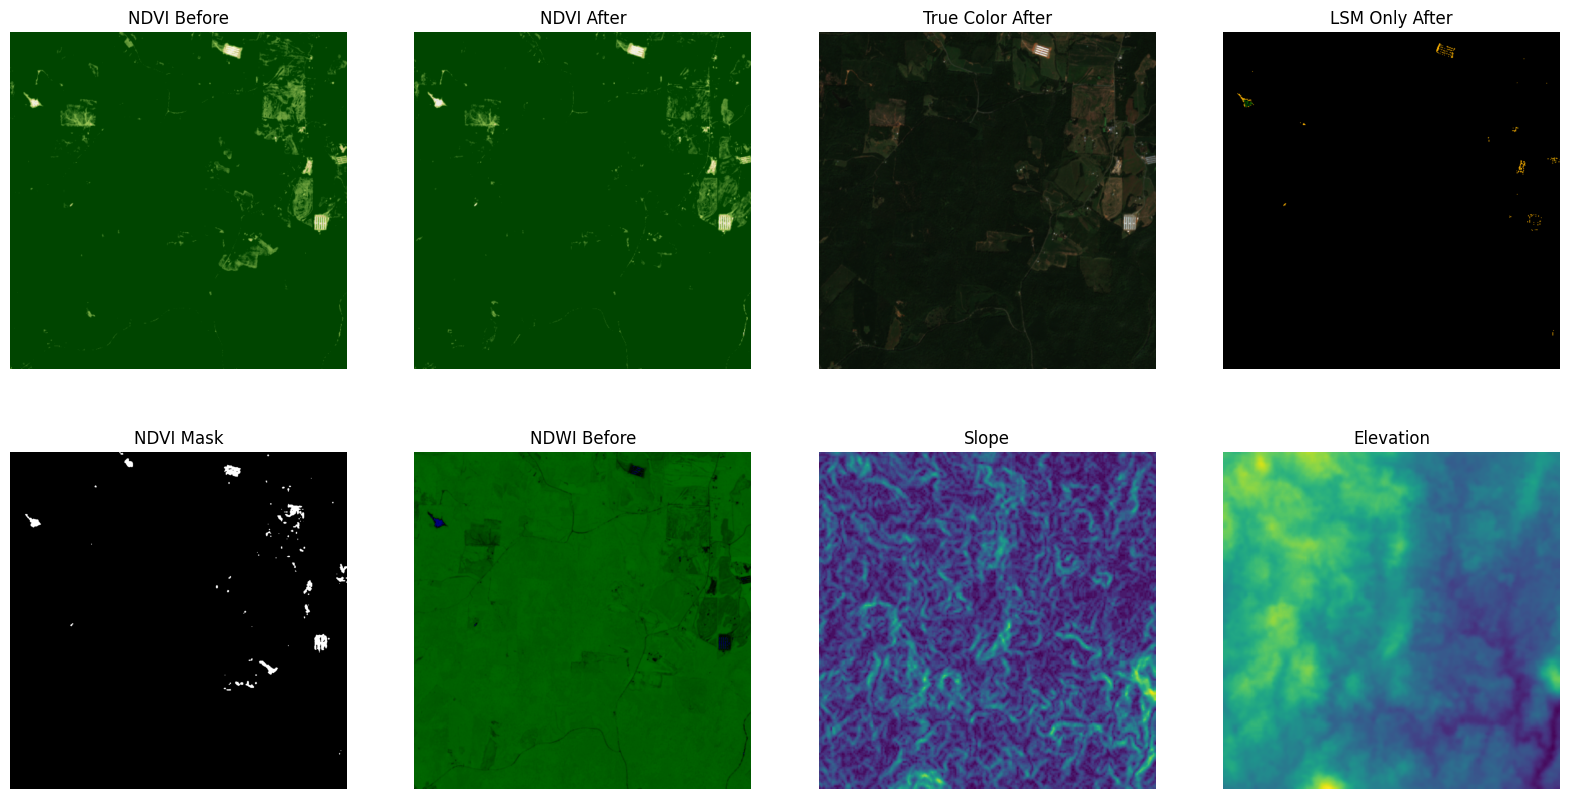

In [24]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.title("NDVI Before")
plt.imshow(NDVI_Before); plt.axis("off")

plt.subplot(2, 4, 2)
plt.title("NDVI After")
plt.imshow(NDVI_After); plt.axis("off")

plt.subplot(2, 4, 3)
plt.title("True Color After")
plt.imshow(True_Color_After); plt.axis("off")

plt.subplot(2, 4, 4)
plt.title("LSM Only After")
plt.imshow(LSM_Only_After); plt.axis("off")

diff = NDVI_Before - NDVI_After
threshold = 0
tolerance = 60
mask = ((NDVI_Before > NDVI_After + tolerance) & (diff > threshold)).astype(np.uint8) * 255
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
mask_resized = cv2.resize(mask, (mask.shape[0]//4, mask.shape[0]//4))
mask = cv2.resize(mask_resized, mask.shape)
mask = cv2.threshold(mask, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

plt.imsave(f"{project_name}/{project_name}-dNDVI-masked.png", mask, cmap='gray')


plt.subplot(2, 4, 5)
plt.title("NDVI Mask")
plt.imshow(mask, cmap='gray'); plt.axis("off")

plt.subplot(2, 4, 6)
plt.title("NDWI Before")
plt.imshow(NDWI_Before); plt.axis("off")

plt.subplot(2, 4, 7)
plt.title("Slope")
plt.imshow(slope_arr); plt.axis("off")

plt.subplot(2, 4, 8)
plt.title("Elevation")
plt.imshow(elevation_arr); plt.axis("off")


plt.show()

In [ ]:
plt.subplot(1, 2, 1)
plt.title("S Only After")
plt.imshow(LSM_Only_After); plt.axis("off")

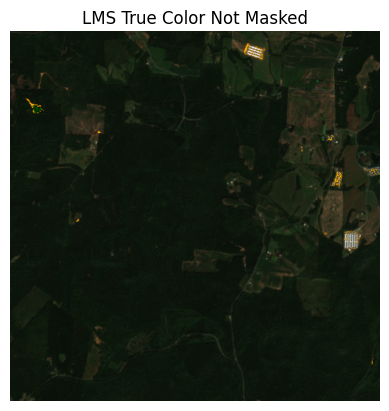

In [87]:
no_mask = np.ones_like(True_Color_After) * 255
LMS_True_Color_dNDVI_not_Masked = True_Color_After.copy()
mask_condition = no_mask == 255
LMS_True_Color_dNDVI_not_Masked[mask_condition] = LSM_Only_After[mask_condition]
black_pixels = np.all(LMS_True_Color_dNDVI_not_Masked == [0, 0, 0], axis=-1)
LMS_True_Color_dNDVI_not_Masked[black_pixels] = True_Color_After[black_pixels]

plt.imshow(LMS_True_Color_dNDVI_not_Masked); plt.axis("off")
plt.title("LMS True Color Not Masked")
plt.imsave(f"{project_name}/{project_name}-LMS_True_Color_dNDVI_Not_Masked.png", LMS_True_Color_dNDVI_not_Masked)

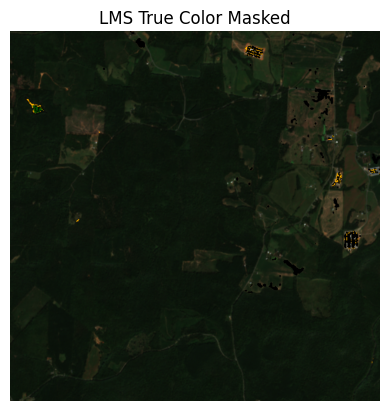

In [88]:
LMS_True_Color_dNDVI_Masked = True_Color_After.copy()
LMS_True_Color_dNDVI_Masked[mask[:,:, None].repeat(3, -1) == 255] = LSM_Only_After[mask[:,:, None].repeat(3, -1) == 255]

plt.imshow(LMS_True_Color_dNDVI_Masked); plt.axis("off")
plt.title("LMS True Color Masked")
plt.imsave(f"{project_name}/{project_name}-LMS_True_Color_dNDVI_Masked.png", LMS_True_Color_dNDVI_Masked)

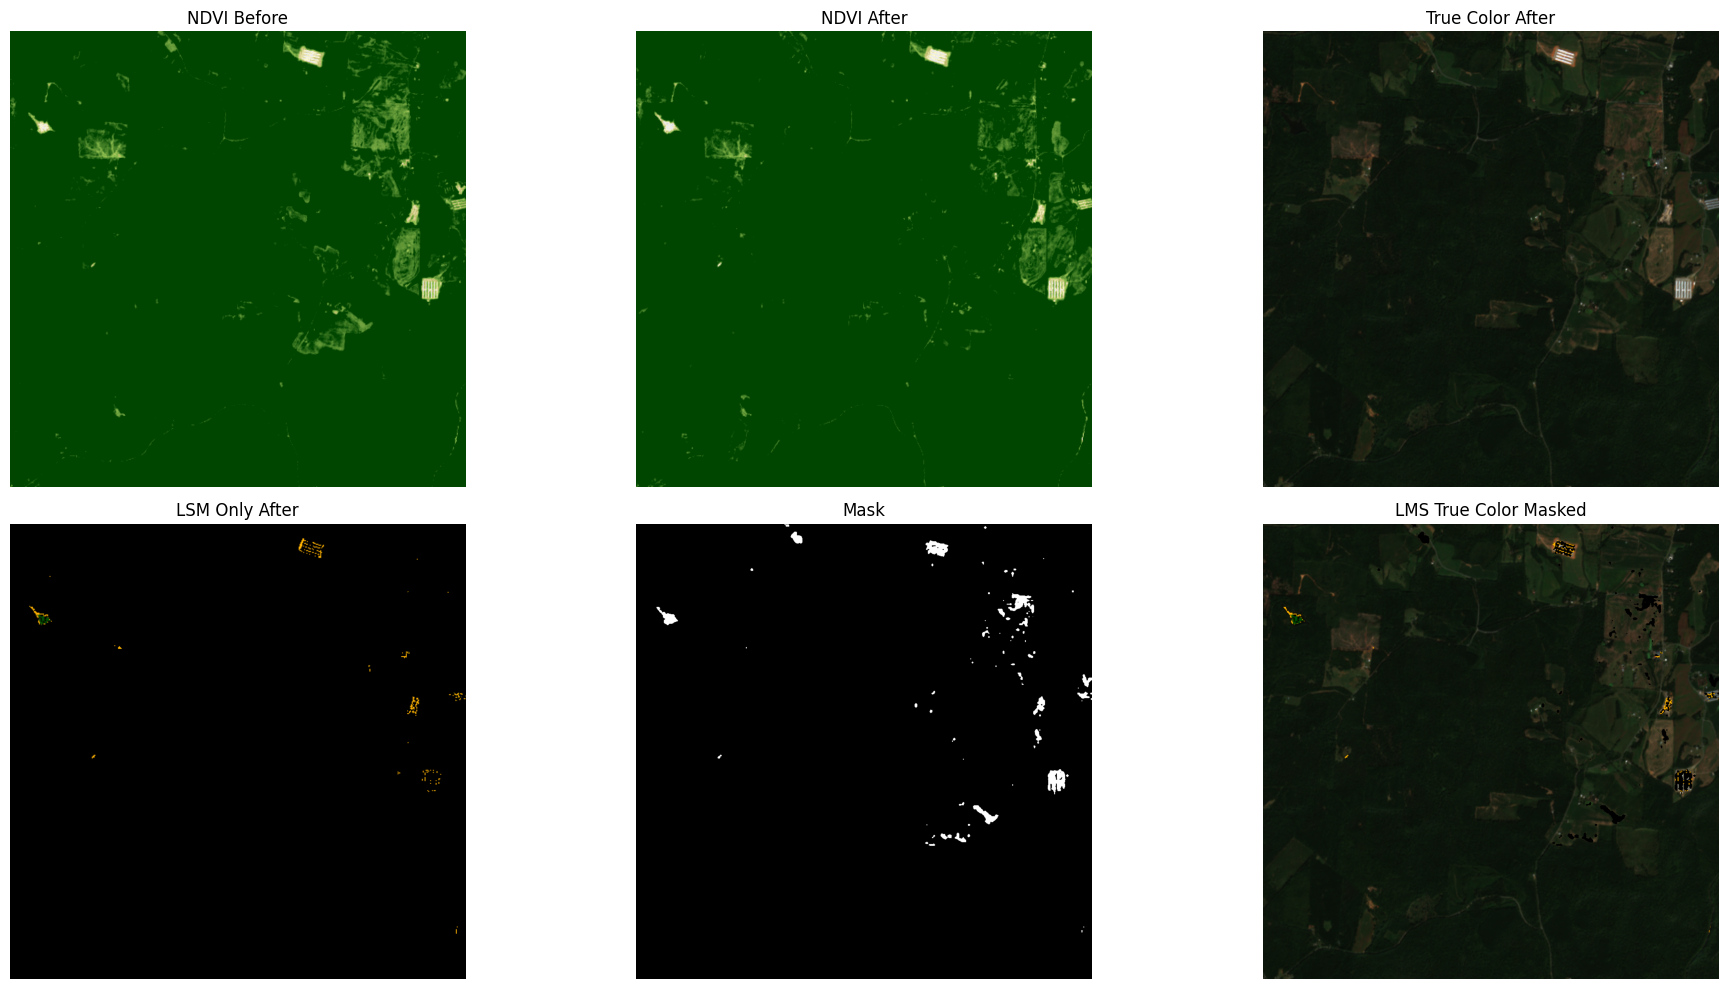

In [89]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# First row
axes[0, 0].imshow(NDVI_Before)
axes[0, 0].set_title("NDVI Before")
axes[0, 0].axis("off")

axes[0, 1].imshow(NDVI_After)
axes[0, 1].set_title("NDVI After")
axes[0, 1].axis("off")

axes[0, 2].imshow(True_Color_After)
axes[0, 2].set_title("True Color After")
axes[0, 2].axis("off")

# Second row
axes[1, 0].imshow(LSM_Only_After)
axes[1, 0].set_title("LSM Only After")
axes[1, 0].axis("off")

# Add the mask visualization in grayscale
axes[1, 1].imshow(mask, cmap="gray")
axes[1, 1].set_title("Mask")
axes[1, 1].axis("off")

# Compute masked image
axes[1, 2].imshow(LMS_True_Color_dNDVI_Masked, cmap="gray")
axes[1, 2].set_title("LMS True Color Masked")
axes[1, 2].axis("off")

plt.tight_layout()
plt.savefig(f"{project_name}/{project_name}-combined_image.png")
plt.show()

In [26]:
project_name

'109 N - Blaine Rd Landslide'

In [96]:
grid

1

In [102]:
LMS_True_Color_dNDVI_Masked.shape

(1000, 1000, 3)

In [113]:
elevation_arr.mean()

0.0

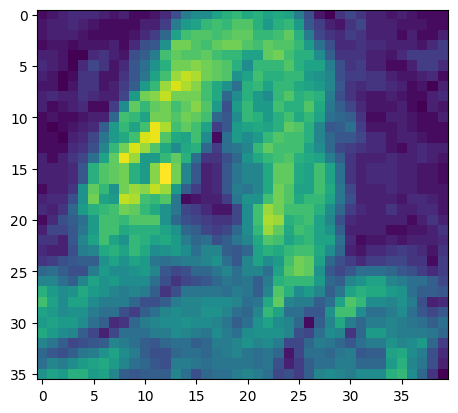

In [127]:
plt.imshow(slope_arr)

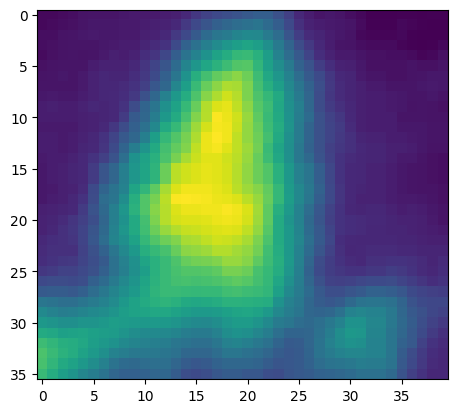

In [128]:
plt.imshow(elevation_arr)

In [15]:
with open("Mapping Automation Completions.txt", "r") as log_file:
    content = [line.strip() for line in log_file]
content

['Hello', 'Bye', 'Wow']